要训练好一个有1.1亿参数的12层BERT-BASE得用16个TPU chips跑上整整4天，花费500镁；24层的BERT-LARGE则有3.4亿个参数，得用64个TPU chips（约7000镁）训练。多次实验得把这些成本乘上几倍。

BERT作者们有开源释出训练好的模型，只要使用TensorFlow或是PyTorch将已训练好的BERT载入，就能省去预训练步骤的所有昂贵成本。

In [0]:
%%bash
pip install tqdm boto3 requests regex -q

In [0]:
! pip install transformers

In [0]:
# ! git clone https://github.com/huggingface/transformers
# % cd transformers
# ! pip install .

In [5]:
import torch
from transformers import BertTokenizer
from IPython.display import clear_output

GITHUB_REPO = "huggingface/pytorch-transformers"
PRETRAINED_MODEL_NAME = "bert-base-chinese"

tokenizer = torch.hub.load(GITHUB_REPO, 'tokenizer', PRETRAINED_MODEL_NAME)

clear_output()
print("PyTorch 版本：", torch.__version__)

PyTorch 版本： 1.4.0


In [6]:
vocab = tokenizer.vocab
print("字典大小：", len(vocab))

字典大小： 21128


## Tokens查看

character-level tokenization，而有 ## 前缀的 tokens 即为wordpieces

In [7]:
import random

random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids):
    print("{0:15}{1:10}".format(t, id))

token               index          
-------------------------
##tar               10216
兀                    1037
攣                    3112
##ith               11440
##涡                 16937
2gb                 11380
1001                11823
##撓                 16112
##ル                  8492
##冥                 14154


### 断句示例

In [8]:
text = "[CLS] 人间四月 [MASK] 飞尽，山寺桃花始盛开。"
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(text)
print(tokens)
print(ids)

[CLS] 人间四月 [MASK] 飞尽，山寺桃花始盛开。
['[CLS]', '人', '间', '四', '月', '[MASK]', '飞', '尽', '，', '山', '寺', '桃', '花', '始', '盛', '开', '。']
[101, 782, 7313, 1724, 3299, 103, 7607, 2226, 8024, 2255, 2191, 3425, 5709, 1993, 4670, 2458, 511]


### 标记



*   [CLS]：输入序列的表征（repr），分类时的输出位置
*   [PAD]：zero padding
*   [SEP]：区分两个句子
*   [UNK]
*   [MASK]：预训练预测对象


## 预测MASK模块

In [9]:
from transformers import BertForMaskedLM


tokens_tensor = torch.tensor([ids])  # (1, seq_len)
# 辨別句子的 segment ids
segments_tensors = torch.zeros_like(tokens_tensor)  # (1, seq_len)

maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)

# 预测
maskedLM_model.eval()
with torch.no_grad():
    outputs = maskedLM_model(tokens_tensor, segments_tensors)
    predictions = outputs[0]   # (1, seq_len, num_hidden_units)
del maskedLM_model

#  top k 最有可能的 tokens
masked_index = 5
k = 3
probs, indices = torch.topk(torch.softmax(predictions[0, masked_index], -1), k)
predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())

print("tokens ：", tokens)
print('-' * 50)
for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
    tokens[masked_index] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens))


tokens ： ['[CLS]', '人', '间', '四', '月', '[MASK]', '飞', '尽', '，', '山', '寺', '桃', '花', '始', '盛', '开', '。']
--------------------------------------------------
Top 1 (55%)：['[CLS]', '人', '间', '四', '月', '花', '飞', '尽', '，', '山', '寺', '桃', '花', '始', '盛', '开', '。']
Top 2 ( 4%)：['[CLS]', '人', '间', '四', '月', '云', '飞', '尽', '，', '山', '寺', '桃', '花', '始', '盛', '开', '。']
Top 3 ( 2%)：['[CLS]', '人', '间', '四', '月', '红', '飞', '尽', '，', '山', '寺', '桃', '花', '始', '盛', '开', '。']


### BertViz可视化

https://github.com/jessevig/bertviz

In [10]:
import sys

! test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
! test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
! pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1061 (delta 25), reused 36 (delta 16), pack-reused 1013
Receiving objects: 100% (1061/1061), 100.13 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (674/674), done.


In [0]:
from transformers import BertTokenizer, BertModel
from bertviz import head_view

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [0]:
model_version = 'bert-base-chinese'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

In [13]:
sentence_a = "他喜欢她。"
sentence_b = "她讨厌他。"

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']

attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

# BertViz
head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## BERT fine tune


1.   准备原始文本数据
1.   将原始文本转换成 BERT 相容的输入格式
2.   在 BERT 之上加入新 layer 成下游任务模型
1.   训练该下游任务模型
2.   对新样本做inference

数据来源和说明：https://www.kaggle.com/c/fake-news-pair-classification-challenge/data

In [0]:
! pip install kaggle

In [0]:
! echo '{"username":"racleray","key":"8dc3f369a98e54d99e389d89a4f2014e"}' > /root/.kaggle/kaggle.json

In [18]:
! kaggle competitions download -c fake-news-pair-classification-challenge

  0% 0.00/176k [00:00<?, ?B/s]
100% 176k/176k [00:00<00:00, 67.2MB/s]
 75% 5.00M/6.64M [00:00<00:00, 29.4MB/s]
100% 6.64M/6.64M [00:00<00:00, 32.5MB/s]
 36% 10.0M/27.8M [00:00<00:00, 18.9MB/s]
100% 27.8M/27.8M [00:00<00:00, 51.6MB/s]


In [19]:
! ls

bertviz_repo  sample_submission.csv.zip  train.csv.zip
sample_data   test.csv.zip


In [20]:
import glob
glob.glob("*.csv.zip")

['test.csv.zip', 'sample_submission.csv.zip', 'train.csv.zip']

#### 处理输入数据

In [22]:
import os
import pandas as pd


os.system("unzip train.csv.zip")

# 去除空白 examples
df_train = pd.read_csv("train.csv")
empty_title = ((df_train['title2_zh'].isnull()) \
               | (df_train['title1_zh'].isnull()) \
               | (df_train['title2_zh'] == '') \
               | (df_train['title2_zh'] == '0'))
df_train = df_train[~empty_title]

MAX_LENGTH = 30
df_train = df_train[~(df_train.title1_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train[~(df_train.title2_zh.apply(lambda x : len(x)) > MAX_LENGTH)]

# 只用 1% 数据查看模型效果
SAMPLE_FRAC = 0.01
df_train = df_train.sample(frac=SAMPLE_FRAC, random_state=9527)

df_train = df_train.reset_index()
df_train = df_train.loc[:, ['title1_zh', 'title2_zh', 'label']]
df_train.columns = ['text_a', 'text_b', 'label']

# 另存成 tsv 供 PyTorch 使用
df_train.to_csv("train.tsv", sep="\t", index=False)

print("样本数量：", len(df_train))
df_train.head()

样本数量： 2657


,text_a,text_b,label
0,苏有朋要结婚了，但网友觉得他还是和林心如比较合适,好闺蜜结婚给不婚族的秦岚扔花球，倒霉的秦岚掉水里笑哭苏有朋！,unrelated
1,爆料李小璐要成前妻了贾乃亮模仿王宝强一步到位、快刀斩乱麻！,李小璐要变前妻了？贾乃亮可能效仿王宝强当机立断，快刀斩乱麻！,agreed
2,为彩礼，母亲把女儿嫁给陌生男子，十年后再见面，母亲湿了眼眶,阿姨，不要彩礼是觉得你家穷，给你台阶下，不要以为我嫁不出去！,unrelated
3,猪油是个宝，一勺猪油等于十副药，先备起来再说,传承千百的猪油为何变得人人唯恐避之不及？揭开猪油的四大谣言！,unrelated
4,剖析：香椿，为什么会致癌？,香椿含亚硝酸盐多吃会致癌？测完发现是谣言,disagreed


label说明：
- agreed: B talks about the same fake news as A
- disagreed: B refutes the fake news in A
- unrelated: B is unrelated to A

In [23]:
# 样本分布
df_train.label.value_counts() / len(df_train)

unrelated    0.679338
agreed       0.294317
disagreed    0.026346
Name: label, dtype: float64

In [24]:
# test样本处理
os.system("unzip test.csv.zip")
df_test = pd.read_csv("test.csv")
df_test = df_test.loc[:, ["title1_zh", "title2_zh", "id"]]
df_test.columns = ["text_a", "text_b", "Id"]
df_test.to_csv("test.tsv", sep="\t", index=False)

print("预测样本数：", len(df_test))
df_test.head()

预测样本数： 80126


,text_a,text_b,Id
0,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,321187
1,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,321190
2,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,321189
3,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,321193
4,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,321191


#### BERT输入格式

In [0]:
# 查看Dataset处理过程
# !pip install pysnooper -q

In [0]:
from torch.utils.data import Dataset


class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "test"]
        self.mode = mode
        # 数据量大时用 iterator=True
        self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("")
        # self.len = len(self.df)
        self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer

    # @pysnooper.snoop()  # 取消注释可已查看处理过程
    def __getitem__(self, idx):
        if self.mode == "test":
            text_a, text_b = self.df.iloc[idx, :2].values
            label_tensor = None
        else:
            text_a, text_b, label = self.df.iloc[idx, :].values
            #  label 文字 >>> tensor
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)

        # tokenize
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)

        tokens_b = self.tokenizer.tokenize(text_b)
        word_pieces += tokens_b + ["[SEP]"]
        len_b = len(word_pieces) - len_a

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)  # to tensor

        # segment tensor
        segments_tensor = torch.tensor([0] * len_a + [1] * len_b,  dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return len(self.df)

In [0]:
trainset = FakeNewsDataset("train", tokenizer=tokenizer)

In [35]:
# 查看trainset

sample_idx = 3
# 原始文本
text_a, text_b, label = trainset.df.iloc[sample_idx].values
# 处理后
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# ids >>> 文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)


print(f"""[原始文本]
句子 1：{text_a}
句子 2：{text_b}
类别  ：{label}

--------------------

[Dataset 输出的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[原文本 tokens_tensors]
{combined_text}
""")

[原始文本]
句子 1：猪油是个宝，一勺猪油等于十副药，先备起来再说
句子 2：传承千百的猪油为何变得人人唯恐避之不及？揭开猪油的四大谣言！
类别  ：unrelated

--------------------

[Dataset 输出的 tensors]
tokens_tensor  ：tensor([ 101, 4343, 3779, 3221,  702, 2140, 8024,  671, 1254, 4343, 3779, 5023,
         754, 1282, 1199, 5790, 8024, 1044, 1906, 6629, 3341, 1086, 6432,  102,
         837, 2824, 1283, 4636, 4638, 4343, 3779,  711,  862, 1359, 2533,  782,
         782, 1546, 2607, 6912,  722,  679, 1350, 8043, 2999, 2458, 4343, 3779,
        4638, 1724, 1920, 6469, 6241, 8013,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

label_tensor   ：2

--------------------

[原文本 tokens_tensors]
[CLS]猪油是个宝，一勺猪油等于十副药，先备起来再说[SEP]传承千百的猪油为何变得人人唯恐避之不及？揭开猪油的四大谣言！[SEP]



#### 创建mask_tensors形成batch

mask_tensors -- mask掉zero padding

In [0]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def create_mini_batch(samples):
    """samples -- FakeNewsDataset实例输出的数据"""
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None

    # padding
    tokens_tensors = pad_sequence(tokens_tensors,  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors,  batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape,  dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids

In [0]:
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [38]:
# 查看batch

data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([64, 63]) 
tensor([[ 101, 5722, 3300,  ...,    0,    0,    0],
        [ 101, 4255, 3160,  ..., 8013,  102,    0],
        [ 101,  711, 2506,  ..., 8013,  102,    0],
        ...,
        [ 101,  671, 2157,  ...,    0,    0,    0],
        [ 101, 1380,  677,  ...,    0,    0,    0],
        [ 101, 2458, 1853,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([64, 63])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([64, 63])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        

## 下游任务创建

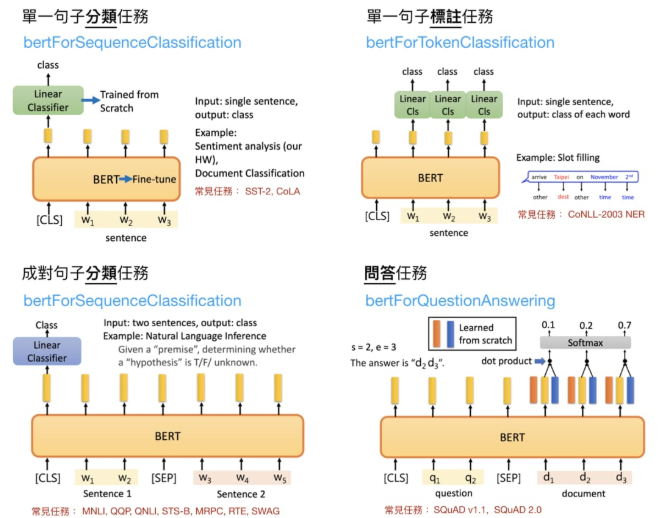![替代文字](https://)

In [0]:
from transformers import BertForSequenceClassification


# 创建预训练分类任务
PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 3

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

In [41]:
print("""
name        module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name        module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


classifier 接在[CLS]对应的输出向量之后

In [42]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "

In [43]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
     
model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
整個模型的參数量：{sum(p.numel() for p in model_params)}
线性分类器的參数量：{sum(p.numel() for p in clf_params)}
""")


整個模型的參数量：102269955
线性分类器的參数量：2307



#### Fine tune

In [0]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            # tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 测试未训练的模型
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)

device: cuda:0
classification acc: 0.16785848701543093


In [46]:
%%time
# fine tune

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 8
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()


        # batch loss
        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))

[epoch 1] loss: 28.582, acc: 0.833
[epoch 2] loss: 17.811, acc: 0.893
[epoch 3] loss: 12.885, acc: 0.933
[epoch 4] loss: 9.251, acc: 0.959
[epoch 5] loss: 6.289, acc: 0.955
[epoch 6] loss: 4.687, acc: 0.950
[epoch 7] loss: 4.494, acc: 0.989
[epoch 8] loss: 2.934, acc: 0.996
CPU times: user 3min 15s, sys: 2min 12s, total: 5min 28s
Wall time: 5min 29s


注意，这是仅仅使用了1%的训练数据的结果

#### Inference

In [47]:
%%time

testset = FakeNewsDataset("test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=128, 
                        collate_fn=create_mini_batch)

predictions = get_predictions(model, testloader)
index_map = {v: k for k, v in testset.label_map.items()}

# 保存输出结果
df = pd.DataFrame({"Category": predictions.tolist()})
df['Category'] = df.Category.apply(lambda x: index_map[x])
df_pred = pd.concat([testset.df.loc[:, ["Id"]],  df.loc[:, 'Category']], axis=1)

df_pred.to_csv('bert_1_prec_training_samples.csv', index=False)
df_pred.head()

CPU times: user 3min 40s, sys: 2min 15s, total: 5min 56s
Wall time: 5min 56s
